# Introduction

L'objectif de ce projet est de ségmenter le comportement des clients en fonction de leurs achats ainsi que de leurs fréquences et quantité d'achats. Ce notebook vous présentera donc l'exploration du dataset initial, avant de préparer un second dataset en vu de la ségmentation des clients. Pour une classification future des clients, un classifieur sera ensuite mis en place pour pouvoir prédire dans quel groupe un utilisateur se situe.

# Plan

<ol>
    <li>Analyse des Features
        <ul>
            <li>Gestion des invoices cancelled</li>
            <li>StockCode</li>
            <li>Description #1</li>
            <li>InvoiceDate</li>
            <li>Prix dépensé dans chaque article</li>
            <li>UnitPrice</li>
            <li>Gestion CustomerID/Country</li>
            <li>Quantity</li>
            <li>Description #2
                <ul>
                    <li>Analyse/Nettoyage des keywords</li>
                    <li>Clustering des articles par keywords</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Exploration Additionnelle
        <ul>
            <li>Panier moyen</li>
            <li>Analyse du CA</li>
        </ul>
    </li>
    <li>Modélisation
        <ul>
            <li>Création des features</li>
            <li>Clustering</li>
        </ul>
    </li>
    <li>Classifieur
        <ul>
            <li>Evaluation des modèles</li>
            <li>Fine-tuning du meilleur modèle</li>
        </ul>
    </li>
</ol>

<b>Pour des raisons de lisibilité, certaines cellules ont été commentés car n'ont été utilise que pour l'exploration mais pas pour la "lecture".</b>

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.manifold import Isomap, TSNE, locally_linear_embedding
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# Analyse des Features

In [3]:
df = pd.read_excel("Online Retail.xlsx")

In [4]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.tail(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [6]:
# df.info()

In [7]:
# df.describe()

Notre dataset possède donc 542000 articles vendus sur une plage de 1 an et 1 semaine de données.
Afin d'explorer les features, un générateur a mis en place permettant d'explorer features par features les données. Pour des raisons de rendu, il a été commenté.

In [8]:
generator = (x for x in df)

In [9]:
col = next(generator)
print(col)
print(df[col].value_counts(), "\n")
print(len(df[df[col].isnull()]), "\n")
print(df[col].describe(), "\n")

InvoiceNo
573585     1114
581219      749
581492      731
580729      721
558475      705
579777      687
581217      676
537434      675
580730      662
538071      652
580367      650
580115      645
581439      635
580983      629
578344      622
538349      620
578347      606
537638      601
537237      597
576617      593
536876      593
536592      592
537823      591
576837      585
579508      578
577078      572
537240      568
577358      561
576618      552
576840      544
           ... 
564728        1
C549533       1
C559531       1
C563587       1
C559193       1
543017        1
543016        1
561271        1
561362        1
C554525       1
542992        1
561392        1
561386        1
561372        1
C545769       1
561368        1
561365        1
561364        1
561361        1
543014        1
561354        1
561333        1
561327        1
561326        1
561323        1
C543388       1
C538357       1
561282        1
C548462       1
C579923       1
Name: InvoiceN

### Gestion des invoice cancelled ou non

Comme expliqué dans la présentation du dataset, les ventes cancelled ont un C en 1ere lettre, on va donc créer une nouvelle feature pour gérer les annulations. Par la suite on va pouvoir re-convertir les numéros de vente en int

In [10]:
df["Cancelled"] = df["InvoiceNo"].str.startswith("C")
df["Cancelled"] = df["Cancelled"].fillna(False)

In [11]:
# df[df["Cancelled"] == True]

Comme une factures annulées ont aussi un Invoice Number unique, on peut donc convertir ces invoices en un numéro aussi

In [12]:
df['InvoiceNo'].replace(to_replace="\D+", value=r"", regex=True, inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('int')

### StockCode

In [13]:
df[["StockCode", "Description"]].head(20)

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.
5,22752,SET 7 BABUSHKA NESTING BOXES
6,21730,GLASS STAR FROSTED T-LIGHT HOLDER
7,22633,HAND WARMER UNION JACK
8,22632,HAND WARMER RED POLKA DOT
9,84879,ASSORTED COLOUR BIRD ORNAMENT


On ne peut pas faire grand chose avec les stocks code. On remarque juste une similarité des articles en foncton de leur clé. Deux clé qui se suivent on parfois des articles très similaire à la différence de la couleur par exemple. De ce fait, on va utiliser les articles pour le classification et on peut supprimer cette feature.

In [14]:
# des codes particuliers ont été trouvé par la suite mais sont supprimés lors du nettoyage via la description 1 donc ils osnt commentés ici

# df[df["StockCode"].str.startswith("DCGS") == True]
# df[df["StockCode"] == "BANK CHARGES"]

### Description #1

Au niveau description, on remarque que la majorité sont en Majuscule sauf certains en minuscule ou avec ???. On va donc creuser un peu

In [15]:
df["Description"].str.islower().sum()

493

On a donc 493 articles vendus qui sont en minuscules. On va donc explorer ces features

In [16]:
df[df["Description"].str.islower() == True].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
6391,536941,22734,amazon,20,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
6392,536942,22139,amazon,15,2010-12-03 12:08:00,0.0,NaN,United Kingdom,False
13217,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,NaN,United Kingdom,False
13218,537426,84968E,check,-35,2010-12-06 15:36:00,0.0,NaN,United Kingdom,False
13264,537432,35833G,damages,-43,2010-12-06 16:10:00,0.0,NaN,United Kingdom,False


Si on explorer un peu plus ces features on en trouve qui commencent avec un point d'interrogation aussi. On va donc aussi les explorer.

In [17]:
df[df["Description"].str.startswith("?") == True].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
7313,537032,21275,?,-30,2010-12-03 16:50:00,0.0,NaN,United Kingdom,False
21518,538090,20956,?,-723,2010-12-09 14:48:00,0.0,NaN,United Kingdom,False
38261,539494,21479,?,752,2010-12-20 10:36:00,0.0,NaN,United Kingdom,False
43662,540100,22837,?,-106,2011-01-04 16:53:00,0.0,NaN,United Kingdom,False
50806,540558,21258,?,-29,2011-01-10 10:04:00,0.0,NaN,United Kingdom,False


On remarque qu'a chaque fois le Client est Nan. On peut donc en conclure que ce sont des frais en charge du magasin (pour remplacer des objets cassés ou d'autres frais). On va donc supprimer ces lignes:

In [18]:
df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.isupper() == True]

# ajouté suite exploration par mot clé plus bas
df = df[df["Description"].str.contains("LOST") == False]

On peut maintenant regarder s'il reste des ventes faite à Nan

In [19]:
df[df["CustomerID"].isnull()][["InvoiceNo","Description"]].head(5)

,InvoiceNo,Description
1443,536544,DECORATIVE ROSE BATHROOM BOTTLE
1444,536544,DECORATIVE CATS BATHROOM BOTTLE
1445,536544,POLKADOT RAIN HAT
1446,536544,RAIN PONCHO RETROSPOT
1447,536544,VINTAGE SNAP CARDS


In [20]:
df[df["CustomerID"].isnull()].groupby("InvoiceNo")["Quantity"].count()

InvoiceNo
536544    525
536555      2
536558      1
536565      2
536592    590
536596      6
536640     11
536755     15
536756     19
536780      4
536801     14
536862     81
536864     47
536865    139
536866      1
536876    592
536883      1
536885     11
536920     10
536982    145
536991      8
537025     15
537220      1
537230      1
537237    595
537240    565
537251     20
537252      1
537253     24
537411      3
         ... 
580604      1
580605      1
580610    269
580612    253
580674      3
580683      2
580699      2
580709      2
580715      1
580724      2
580729    718
580730    659
580732      4
580739      2
580748      4
580754     72
580976      1
580983    627
581023    215
581197      8
581217    673
581219    747
581238    204
581256     62
581431      7
581435      2
581439    631
581492    728
581497     59
581498    218
Name: Quantity, Length: 1535, dtype: int64

On remarque de ce sont beaucoup des gros achats donc potentiellement fait par le magasin pour de la decoration par exemple ou pour refaire l'inventaire à cause de vols. On va donc supprimer toutes les ventes faite au magasin

In [21]:
df = df[df["CustomerID"].notnull()]

### InvoiceDate

Concernant la date des achats, on peut decouper la date par jour/moment de la journée (matin/midi/apres midi). Cela permettra  potentiellement de trouver une correlation. Par exemple on peut imaginer que les particuliers auront plus tendant à acheter en fin de journée (après le travail) ou le week-end alors que les société acheteront plus en journée.

In [22]:
df["Weekday"] = df["InvoiceDate"].dt.weekday

In [23]:
df["Time"] = df["InvoiceDate"].dt.hour

In [24]:
def convert_to_moment(x):
    if 6 <= x <12:
        return "Morning"
    elif 12 <= x < 17:
        return "Afternoon"
    elif 17 <= x <=20:
        return "Late"

df["Time"] = df["Time"].apply(convert_to_moment)

In [25]:
df = pd.concat([df, pd.get_dummies(df['Time'])], axis=1)

In [26]:
df.drop("Time", axis=1, inplace=True)

On peut aussi en profiter pour enregister dans une feature additionnelle, l'ancienneté de l'achat

In [27]:
now = df["InvoiceDate"].max()
df["Recency"] = now-df["InvoiceDate"]
df["Recency"] = pd.to_timedelta(df["Recency"]).astype("timedelta64[D]")

### Prix dépensé dans chaque objets

Une feature additionnelle va être crée aussi pour avoir le Prix total par article. Cette feature servira a connaitre le panier total

In [28]:
df["Price"] = df["UnitPrice"] * df["Quantity"]

### UnitPrice

On peut regarder la répartion du prix des articles afin de detecter de possibles outliers

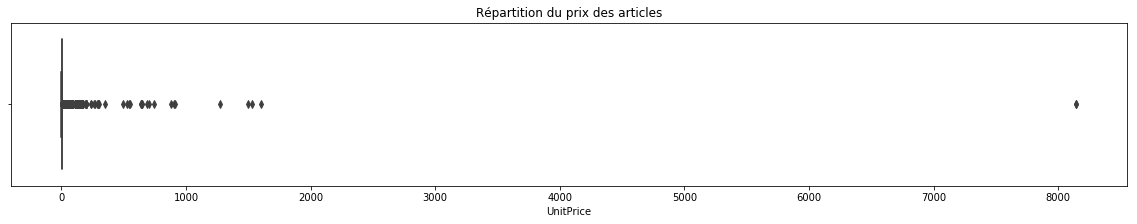

In [29]:
plt.figure(figsize=(20,3))
sns.boxplot(df["UnitPrice"])
plt.title("Répartition du prix des articles")
plt.savefig("img/price_raw.png")
plt.show()

On remarque qu'il y a quelques points dont le prix unitaire est très élevé. On peut donc regarder ce que c'est

In [30]:
df[df["UnitPrice"]>200].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145.0,United Kingdom,False,3,0,1,0,371.0,295.0
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607.0,United Kingdom,False,3,0,0,1,358.0,295.0
36165,539438,22655,VINTAGE RED KITCHEN CABINET,-1,2010-12-17 15:11:00,295.0,16607.0,United Kingdom,True,4,1,0,0,356.0,-295.0
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom,False,0,1,0,0,332.0,295.0
51674,540652,22655,VINTAGE RED KITCHEN CABINET,-1,2011-01-10 15:04:00,265.5,17406.0,United Kingdom,True,0,1,0,0,332.0,-265.5


On remarque que 2 Staock Code reviennet souvent (DOT  et POST)

In [31]:
df[df["StockCode"] == "DOT"].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
317507,564764,DOT,DOTCOM POSTAGE,1,2011-08-30 10:49:00,11.17,14096.0,United Kingdom,False,1,0,0,1,101.0,11.17
324002,565383,DOT,DOTCOM POSTAGE,1,2011-09-02 15:45:00,16.46,14096.0,United Kingdom,False,4,1,0,0,97.0,16.46
333755,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,13.16,14096.0,United Kingdom,False,4,1,0,0,90.0,13.16
338829,566566,DOT,DOTCOM POSTAGE,1,2011-09-13 12:32:00,85.58,14096.0,United Kingdom,False,1,1,0,0,87.0,85.58
350599,567656,DOT,DOTCOM POSTAGE,1,2011-09-21 14:40:00,878.55,14096.0,United Kingdom,False,2,1,0,0,78.0,878.55


StockCode DOT représente les frais d'envoi au Royaume Uni (via DOTCOM POSTAGE) et POST concerne les envois à l'étranger. Cela se voir via la feature Country. Comme ces couts ne représente pas vraiment les ventes mais sont juste la pour compenser les frais d'envoi, on va supprimer ces lignes.

In [32]:
df = df[(df["StockCode"] != "DOT") & (df["StockCode"] != "POST")]

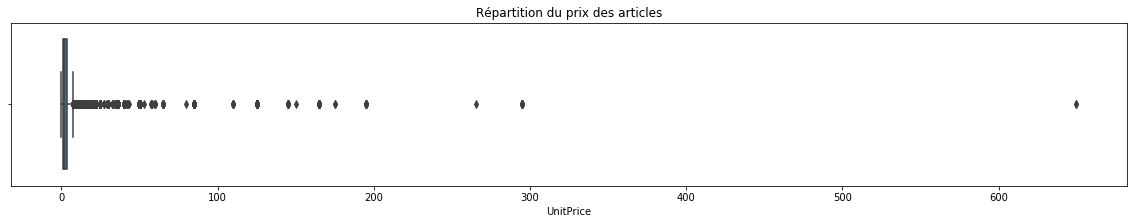

In [33]:
plt.figure(figsize=(20,3))
sns.boxplot(df["UnitPrice"])
plt.title("Répartition du prix des articles")
plt.savefig("img/price_clean.png")
plt.show()

Il reste beaucoup de points très au dessus de la moyenne. Cependant, cela correspondent vraiement à des articles couteux. De ce fait, on ne les supprime pas.

### Gestion CustomerID/Country

On peut regarder la nationalité des clients. Elle sera comparé au CA. Si 10% des clients sont étrangers mais rapportent 30% du CA, ca vaut le coup de les garder. S'ils représentent 1 % du C/A, alors ils pourront être ignorés.

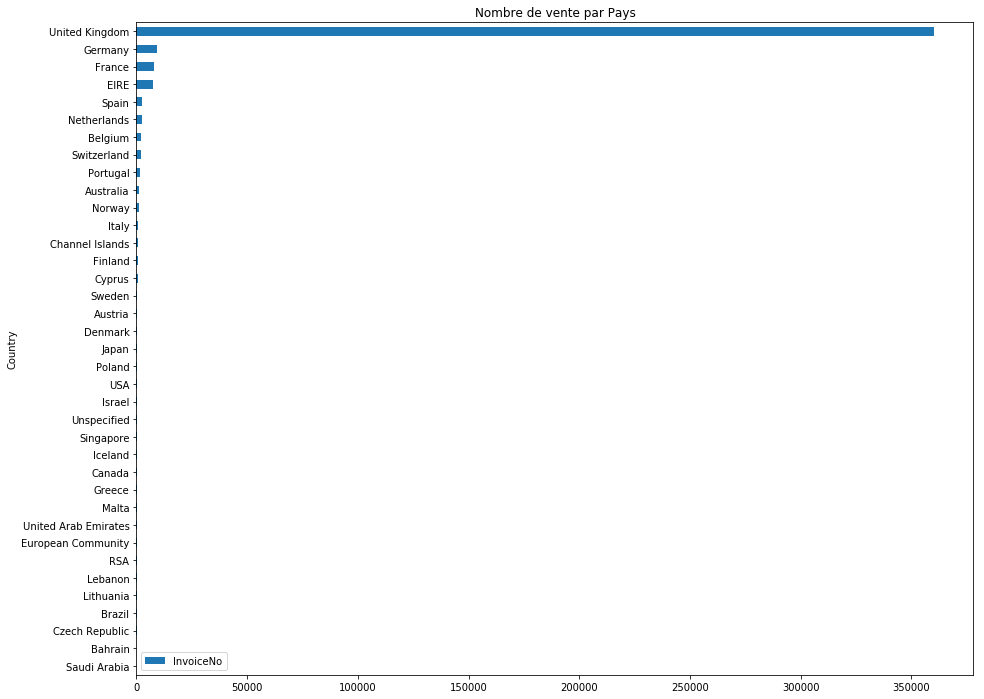

In [34]:
repartition = df.groupby("Country").agg({
    "InvoiceNo" : "count"
}).sort_values("InvoiceNo").reset_index()

repartition.set_index("Country").plot(kind='barh', figsize=(15,12))
plt.title("Nombre de vente par Pays")
plt.savefig("img/nb_vente.png")
plt.show()

In [35]:
repartition[repartition["Country"] == "United Kingdom"]["InvoiceNo"].values/repartition["InvoiceNo"].sum()

array([ 0.89183304])

89 % des ventes sont faites par des clients au Royaume Uni. Afin de savoir si l'on peut supprimer les clients hors Royaume-Uni, on peut regarder leur apport dans le CA

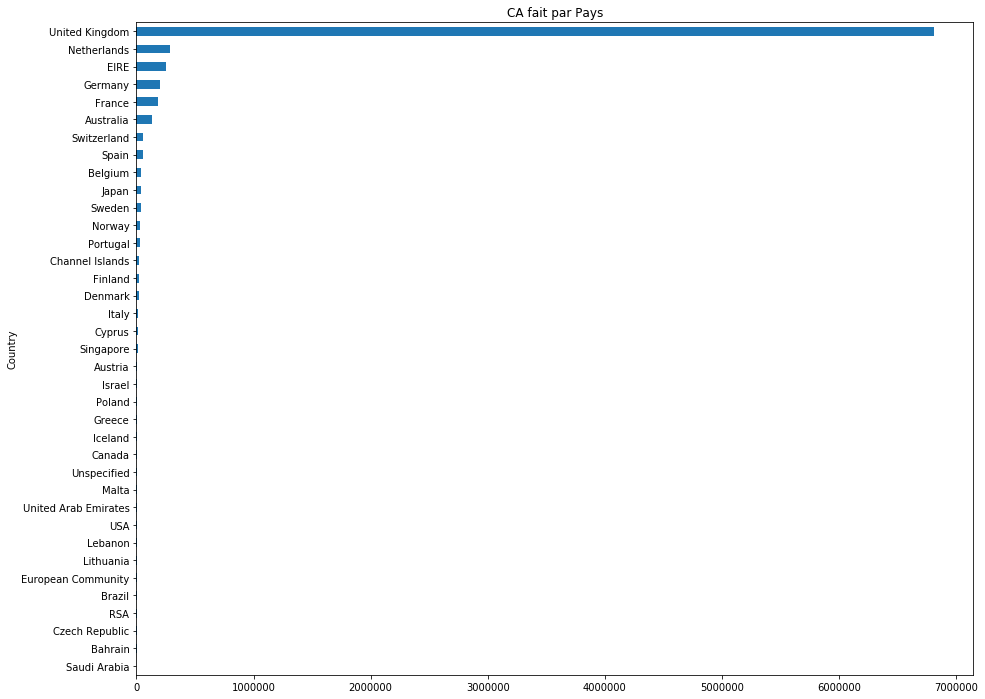

In [36]:
CA_per_countries = df.groupby(["Country"])["Price"].sum().sort_values()

CA_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("CA fait par Pays")
plt.savefig("img/ca_vente.png")
plt.show()

In [37]:
CA_per_countries["United Kingdom"]/CA_per_countries.sum()

0.82263452551421146

10% des ventes sont faite à l'etranger mais représente 18 % des revenues, de ce fait on va garder la feature Country. Pour l'encoding, on va utiliser leur calssement en apport

In [38]:
# print(list(CA_per_countries.index[::-1]))

On peut maintenant encoder le dataset en fonction de leur classement et sauvegarder ce dictionnaire pour la partie production

In [39]:
decoder_countries = {i: j for i, j in enumerate(CA_per_countries.index[::-1]) }
encoder_countries = {j: i for i, j in enumerate(CA_per_countries.index[::-1]) }

df["Country"] = df["Country"].apply(lambda x:encoder_countries[x])

save_obj(decoder_countries, "decoder_countries")
save_obj(encoder_countries, "encoder_countries")

### Quantity

Sur cette feature, il n'y a pas grand chose a dire non plus, on a le prix unitaire et le nombre acheté. Les achats négatifs sont les achats annulés donc on en a plus si on filtre suivant cette feature. 

In [40]:
df[df["Cancelled"] == False]["Quantity"].describe()

count    395147.000000
mean         13.019659
std         180.876808
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

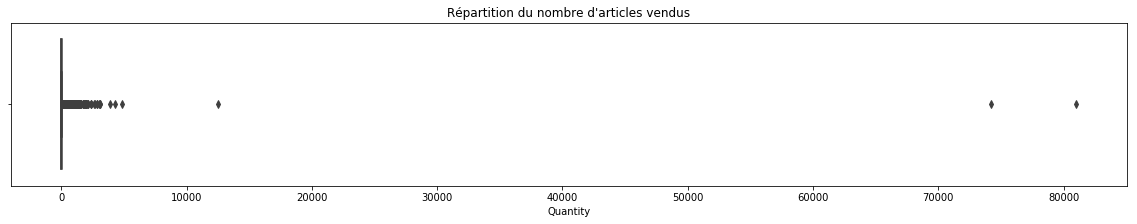

In [41]:
plt.figure(figsize=(20,3))
sns.boxplot(df[df["Cancelled"] == False]["Quantity"])
plt.title("Répartition du nombre d'articles vendus")
plt.savefig("img/qty_raw.png")
plt.show()

Comme on l'a fait avec les prix unitaire, si on regarde les achats en grosse quantité, on peut regarder si ceux l'on retrouve pour chaque vente annulé, l'achat correspondant. Comme on n'est a pas beaucoup, on peut le faire à la main

In [42]:
print(df[(df["Cancelled"] == False) & (df["Quantity"] > 2000)]["Quantity"])
print(df[(df["Cancelled"] == True) & (df["Quantity"] < -2000)]["Quantity"])

4945       2880
32671      2400
52711      3114
61619     74215
80742      2592
87631      2400
97432      3906
125282     2160
160546     3114
201149     2700
206121     4300
291249     2880
421601     2400
421632     4800
433788     3000
437480     2100
502122    12540
511421     2040
540421    80995
Name: Quantity, dtype: int64
4287      -9360
61624    -74215
160145    -3114
540422   -80995
Name: Quantity, dtype: int64


On remarque que les 2 principaux outliers ont été annulés ainsi qu'un 3eme, on peut donc les supprimer. Par contre cette méthode ne marche pas particulièrement pour les petites quantité car parfois les clients ramènent qu'une parti de leur achat.

In [43]:
qte_false = [74215, 3114, 80995]
for qte in qte_false:
    df = df[(df["Cancelled"] == False) & (df["Quantity"] !=qte)]

Si on regarde ensuite l'orfre par exemple avec 12000 articles, on peut voir que le client n'a pas ramené le produit car il n'y a pas de 2nd invoice pour cet ID de client et aucun invoice a pour quantité -12540

In [44]:
df[df["Quantity"] == 12540]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,0,False,4,1,0,0,13.0,0.0


In [45]:
df[df["CustomerID"] == 13256.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled,Weekday,Afternoon,Late,Morning,Recency,Price
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,0,False,4,1,0,0,13.0,0.0


On peut regarder maintenant le boxplot post nettoyage. On remarque qu'il y a beucoup d'outliers mais qui sont des vraies données, on doit donc les garder

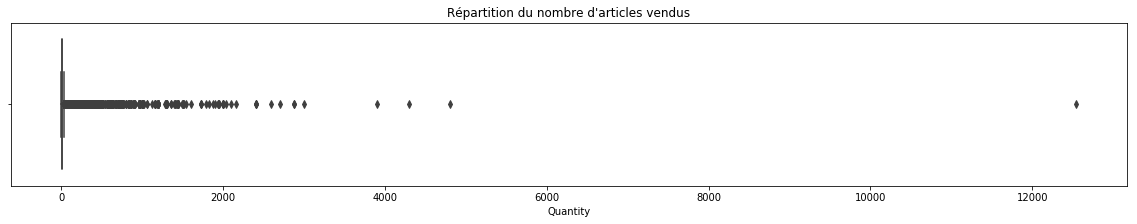

In [46]:
plt.figure(figsize=(20,3))
sns.boxplot(df[df["Cancelled"] == False]["Quantity"])
plt.title("Répartition du nombre d'articles vendus")
plt.savefig("img/qty_clean.png")
plt.show()

### Description #2

Les mot clé seront difficilement gérable et parfois menant sur des fausses pistes ( ex avec les couleurs). Du coup on va s'ocduper des données pour faire un OHE. L'objectif étant de grouper les objets similaires (exemple une table blanche et une table rouge)

<ul>
<li>22              RED COAT RACK PARIS FASHION</li>
<li>23           YELLOW COAT RACK PARIS FASHION</li>
<li>24             BLUE COAT RACK PARIS FASHION</li>
</ul>

<ul>
<li>3887              LETTER "F" BLING KEY RING</li>
<li>3888              LETTER "O" BLING KEY RING</li>
<li>3889              LETTER "T" BLING KEY RING</li>
<li>3890              LETTER "U" BLING KEY RING</li>
<li>3891              LETTER "W" BLING KEY RING</li>
<li>3892              LETTER "Z" BLING KEY RING</li>
</ul>

#### Analyse/Nettoyage des keywords

Pour cette analyse, une série de regexp va être utilisée pour supprimer certains mots/caractères. L'objectif étant de minimiser le nombre de mots clé pour pourvoir ensuite faire un Clustering basé sur les mots clé de chauqe articles.

Dans un premier temps, un second dataset listant les objets va être crée. Sur ceux-ci les mots clé vont être extrait dans n-features pour effectuer un clustering pour avoir ensuite pour chaque objet son cluster.

In [47]:
df_obj = df["Description"].drop_duplicates().reset_index(drop=True).to_frame()

# On fait une colonne pour les objets nettoyés
df_obj["Keywords"] = df_obj["Description"]

Les 3 cellules suivantes ont été utilise pour determiner les regexp a utiliser. Elles sont commentés car inutiles désormais

In [48]:
# df_obj["Keywords"].drop_duplicates()

In [49]:
# keywords = df_obj["Keywords"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False)
# a = 0
# for index, word in keywords.iteritems():
#     print(index)

In [50]:
# df_obj[df_obj["Keywords"].str.contains(" YOU ")].drop_duplicates()

In [51]:
pat = r"RED|BLUE|PINK|BLACK|WHITE|GREEN|ROSE|SILVER|IVORY|YELLOW|LAVENDER|TURQUOISE|PURPLE|ORANGE|BROWN"  # suppression couleurs
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [52]:
pat = r"LARGE|MEDIUM|SMALL"  # suppresion taille
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [53]:
pat = r"OF|THE|IN|AND|WITH|ON|TO"  # suppresion mot fréquents inutile
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [54]:
df_obj["Keywords"] = df_obj["Keywords"].str.replace("CLES", "CLE")
df_obj["Keywords"] = df_obj["Keywords"].str.replace("HEARTS", "HEART")
df_obj["Keywords"] = df_obj["Keywords"].str.replace("'S", "")

In [55]:
pat = r"[a-z]+" # suppression des keywords en minuscule
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [56]:
pat = r"\d" # suppression des chiffres
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, '')

In [57]:
pat = r"[,.!&/+\"]"  # suppression de caractères spécieux
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, " ")

In [58]:
pat = r"\s[A-Z]\s"
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, "")

In [59]:
pat = r"\s+"  # suppression des double espaces
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, " ")

In [60]:
df_obj["Keywords"] = df_obj["Keywords"].str.strip()

On peut maintenant regarder le résultat

In [61]:
df_obj.head(10)

,Description,Keywords
0,WHITE HANGING HEART T-LIGHT HOLDER,HANGG HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN,METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER,CREAM CUPID HEART COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE,KNITTED UNI FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.,WOOLLY HOTTIE HEART
5,SET 7 BABUSHKA NESTING BOXES,SET BABUSHKA NESTG BOXES
6,GLASS STAR FROSTED T-LIGHT HOLDER,GLASS STAR FROSTED T-LIGHT HOLDER
7,HAND WARMER UNION JACK,H WARMER UNI JACK
8,HAND WARMER RED POLKA DOT,H WARMER POLKA DOT
9,ASSORTED COLOUR BIRD ORNAMENT,ASSORTED COLOUR BIRD ORNAMENT


<b>Les regexp suivantes n'ont pas été utilisées car détruisant un peu trop le sens</b>

In [62]:
# pat = r".*T-LIGHT HOLDER.*"
# df_obj = df_obj.str.replace(pat, 'T-LIGHT HOLDER')

In [63]:
# pat = r".*(NECKLACE|BAG CHARM|BRACELET|GLOVES?).*"
# df_obj = df_obj.str.replace(pat, r'\1')

# pat = r".*GLOVES?.*"
# df_obj = df_obj.str.replace(pat, r'GLOVES')

In [64]:
# pat = r".*(JUMBO|CHARLOTTE|LUNCH|SHOULDER|GIFT|SHOPPER).*BAG.*"
# df_obj = df_obj.str.replace(pat, r'\1 BAG')

In [65]:
# pat = r".*(CARDS?|MUG).*"
# df_obj = df_obj.str.replace(pat, r'\1')

In [66]:
# pat = r".*(BON BON|SWEET|JAM).*JAR.*"
# df_obj = df_obj.str.replace(pat, r'\1 JAR')

In [67]:
# pat = r".*(CAKE CASES).*"
# df_obj = df_obj.str.replace(pat, r'\1')

In [68]:
# pat = r".*(POPPY S PLAYHOUSE|BUILDG BLOCK WORD|SNACK TRAY).*"
# df_obj = df_obj.str.replace(pat, r'\1')

In [69]:
# pat = r".*(CUSHION|PASSPORT|FOOD).*COVER.*"
# df_obj = df_obj.str.replace(pat, r'\1 COVER')

# pat = r".*COVER.*(CUSHION|PASSPORT|FOOD).*"
# df_obj = df_obj.str.replace(pat, r'\1 COVER')

Ce nettoyage a été privilégier car faire un OHE sur le dataset complet aurait été tres grourmand (400 000 ventes x 4000 objets). Cette méthode permet d'avoir une matrice de 4000 objets x N keywords. Dans ce cas, on va garder les mots clé qui en cumulé permet de garder 95 % de apparitions

<b>EDIT : </b> Dans un premier temps, le clustering a été fait avec les 1300 premiers mots clés. Cependant le résultat du clustering est très impacté par les principaux mots clé qui peuvent représenter tous les objets. Du coup on va en supprimer certains qui décrivent leur forme par exemple ou le type de produit

In [70]:
for word in ["SET", "HEART", "VTAGE", "BOX", "DESIGN", "FLOWER", "METAL", "RETROSPOT", "POLKADOT", "CHRISTMAS", "GLASS"]:
    df_obj["Keywords"] = df_obj["Keywords"].str.replace(word, "")

pat = r"\s+"  # suppression des double espaces
df_obj["Keywords"] = df_obj["Keywords"].str.replace(pat, " ")

df_obj["Keywords"] = df_obj["Keywords"].str.strip()

In [71]:
CS = df_obj["Keywords"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False).cumsum().reset_index()
CS.columns = ["keyword", "CS"]
CS.head(5)

,keyword,CS
0,BAG,157.0
1,CLE,294.0
2,HOLDER,410.0
3,HANGG,511.0
4,DECORATI,609.0


In [72]:
limite = CS['CS'].values.max()*0.95
index_max = (CS["CS"]<limite).sum()
print(limite, index_max)

11553.9 1358


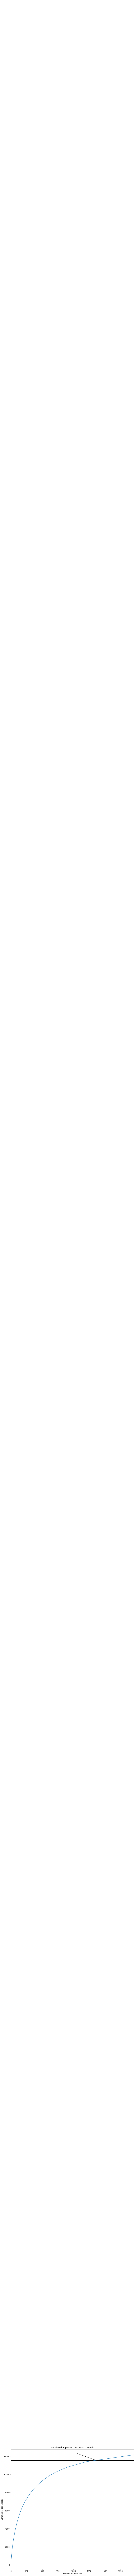

In [73]:
CS['CS'].plot(figsize=(12,12))
plt.title("Nombre d'appartion des mots cumulés")
plt.xlabel("Nombre de mots clés")
plt.ylabel("Somme des apparitions")
plt.axvline(x=index_max, linewidth=3, color='k')
plt.hlines(y=limite, xmin=0, xmax = 2000, linewidth=3, color='k')
plt.savefig("img/keyword_cs.png")
plt.annotate(xy = (350, 14100), s="Point conservant 95% de l'appartion des mots")
plt.arrow(index_max, limite, -300, 750, hold=None)
plt.show()

On récupère donc les 1300 mots conservées

In [74]:
keywords_selected = CS["keyword"].tolist()[:index_max]

Et on fait donc un OHE sur chaque mot en fonction des mots clé

In [75]:
unique_key_obj = df_obj["Keywords"].drop_duplicates().to_frame()

In [76]:
# génération des colonnes
for key in keywords_selected:
    unique_key_obj[key] = 0

# Remplissage des lignes
for index, row in unique_key_obj.iterrows():
    for word in row["Keywords"].split(" "):
        if word in keywords_selected:
            unique_key_obj.loc[index, word] = 1  

In [77]:
factor = 1
for col in list(unique_key_obj)[1:]:
    unique_key_obj[col] = unique_key_obj[col] * 0.99
    factor *= 0.99

In [78]:
unique_key_obj.head(5)

,Keywords,BAG,CLE,HOLDER,HANGG,DECORATI,WALL,T-LIGHT,PAPER,CAKE,...,BROCADE,TREEANGEL,TREASUREGYMKHANA,CEY,TAPER,TREASUREBUFFALO,BRZE,TAPES,WILD,CENTURY
0,HANGG T-LIGHT HOLDER,0.0,0.0,0.99,0.99,0.0,0.0,0.99,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LANTERN,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CREAM CUPID COAT HANGER,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,KNITTED UNI FLAG HOT WATER BOTTLE,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,WOOLLY HOTTIE,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Comme notre matrice est un OHE, on n'a pas besoin de  faire de Scaling. On peut appliquer directement le Kmeans. En fonction du facteur de silhoutette on va choisir le nb de cluster pour notre modèles. 

#### Clustering des articles par keywords

In [80]:
X = unique_key_obj.drop("Keywords", axis=1)

n_cluster_opti = 0
max_silhouette = -1
for n_clusters in range(3,50):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > max_silhouette:
        n_cluster_opti = n_clusters

For n_clusters = 3 The average silhouette_score is : 0.0331737168947
For n_clusters = 4 The average silhouette_score is : 0.0148009112882
For n_clusters = 5 The average silhouette_score is : 0.0309886060133
For n_clusters = 6 The average silhouette_score is : 0.0257985644574
For n_clusters = 7 The average silhouette_score is : 0.0360254715012
For n_clusters = 8 The average silhouette_score is : 0.014771148931
For n_clusters = 9 The average silhouette_score is : 0.0391803942612
For n_clusters = 10 The average silhouette_score is : 0.00928636969917
For n_clusters = 11 The average silhouette_score is : 0.020778969352
For n_clusters = 12 The average silhouette_score is : -0.00328281289972
For n_clusters = 13 The average silhouette_score is : 0.0307212590594
For n_clusters = 14 The average silhouette_score is : 0.0389106659388
For n_clusters = 15 The average silhouette_score is : 0.0506304330481
For n_clusters = 16 The average silhouette_score is : 0.0364969826422
For n_clusters = 17 The av

En fonction des essais, on a un nombre de clusters variables. Pour la suite il a été fixé a 38 (meilleur lors d'un précédent essai)

In [81]:
kmeans = KMeans(init='k-means++', n_clusters = n_cluster_opti, n_init=30)
kmeans.fit(X)
unique_key_obj["Cluster"] = kmeans.labels_ 
X_embedded = kmeans.fit_transform(X)

On peut afficher le résultat du Kmeans en 3D

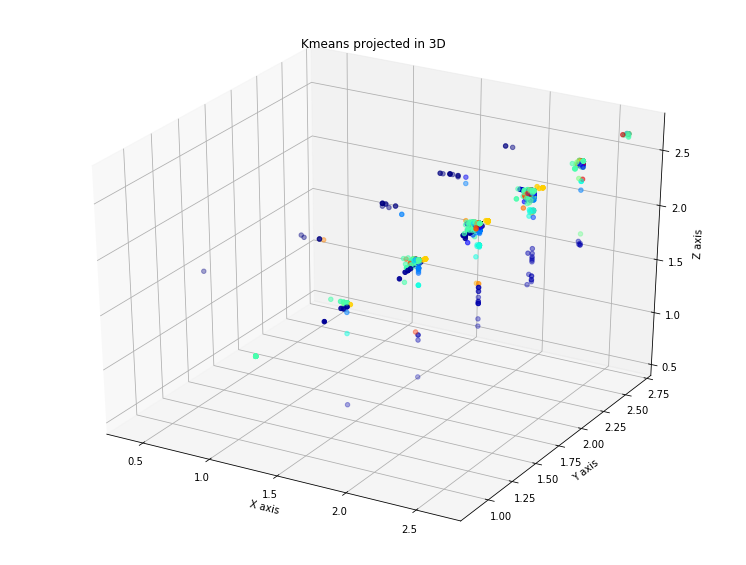

In [82]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=kmeans.labels_, cmap="jet")
plt.title("Kmeans projected in 3D")
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.savefig("img/kmeans3d_obj.png")
plt.show()

Une autre approche serait d'utiliser le TSNE pour visualiser les regroupements et les couleurs pour les labels (pour éviter de refaire le calcul à chauqe fois, l'image est mise dans une balise image)

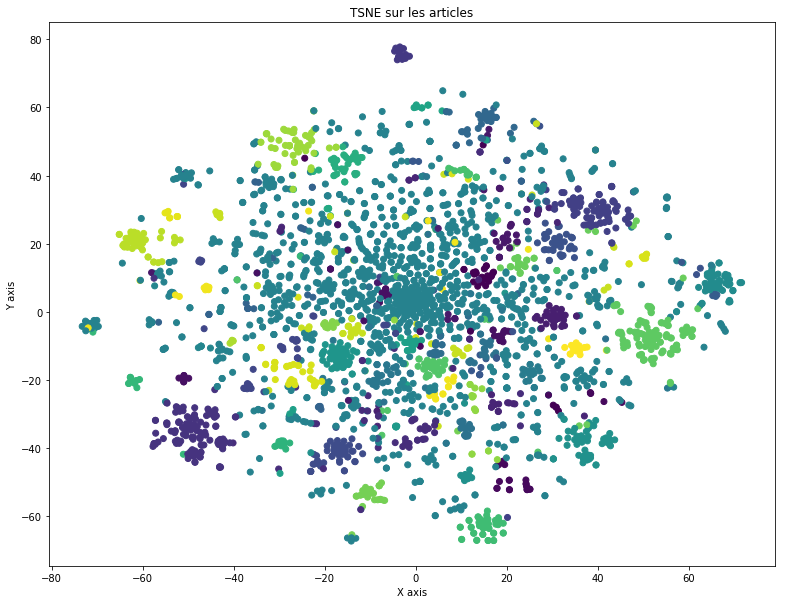

In [83]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X)
color = kmeans.labels_

plt.figure(figsize=(13,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color)
plt.title("TSNE sur les articles")
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.savefig("img/TSNE_articles_2D_filtered.png")
plt.show()

Avant la suppresision des mots clé, le clustering avait beaucoup ples de cluster (37) et ressembalit à :

<img src="img/TSNE_articles_2D.png"/>

On remarque que les clusters sont biens regroupés. Il faut maintenant assigné en fonction des mots clé les lables aux objets initiaux

In [84]:
df_obj = df_obj.set_index('Keywords').join(unique_key_obj[["Keywords", "Cluster"]].set_index('Keywords')).reset_index()

On peut aussi regarder le contenu des clusters

In [85]:
df_obj[df_obj["Cluster"] == 21]

,Keywords,Description,Cluster
161,ASSTD PAPER STICKERS,ASSTD DESIGN 3D PAPER STICKERS,21
272,BELL HEYCOMB PAPER,WHITE BELL HONEYCOMB PAPER,21
273,BELL HEYCOMB PAPER GARL,WHITE BELL HONEYCOMB PAPER GARLAND,21
476,CALENDAR PAPER CUT,CALENDAR PAPER CUT DESIGN,21
633,CHESE DRAG PAPER LANTERNS,CHINESE DRAGON PAPER LANTERNS,21
775,COLLAGE PAPER CUPS,SET/6 COLLAGE PAPER CUPS,21
776,COLLAGE PAPER PLATES,SET/6 COLLAGE PAPER PLATES,21
892,CUPCAKE LACE PAPER,CUPCAKE LACE PAPER SET 6,21
922,D HEYCOMB PAPER GARL,3D HEARTS HONEYCOMB PAPER GARLAND,21
944,DAISY PAPER LAMPSHADE,RED DAISY PAPER LAMPSHADE,21


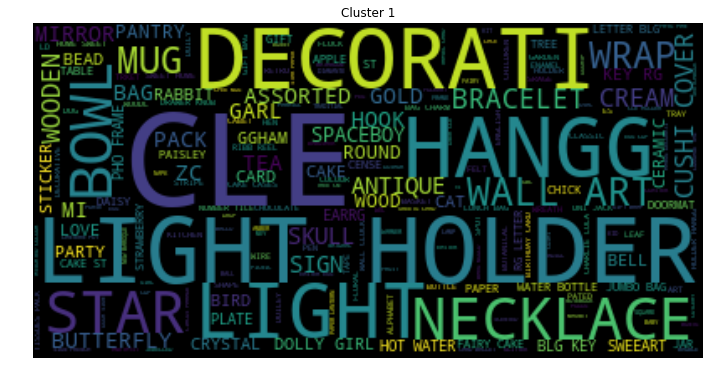

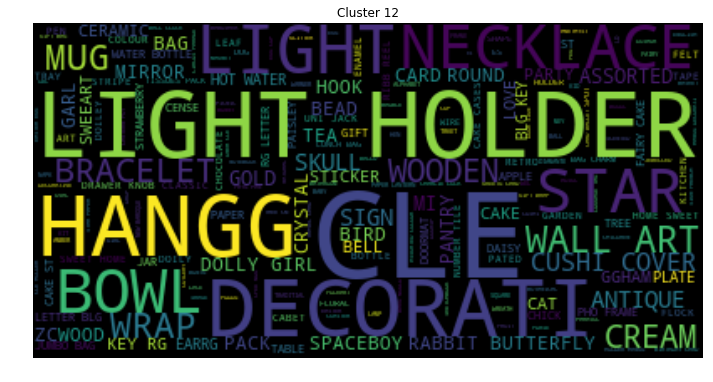

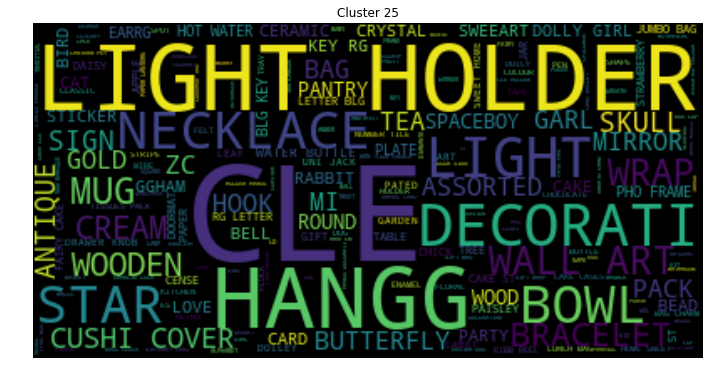

In [86]:
for cluster_num in [1, 12, 25]:
    text = " ".join(df_obj[df_obj["Cluster"] == cluster_num]["Keywords"].tolist())

    wordcloud = WordCloud()
    # wordcloud.generate_from_frequencies(frequencies=cnt)
    wordcloud.generate(" ".join(df_obj["Keywords"].tolist()))
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster {}".format(cluster_num))
#     plt.savefig("img/c{}_cloud.png".format(cluster_num))
    plt.show()

In [87]:
save_obj(df_obj.set_index("Description")["Cluster"].to_dict(), "dict_obj_cluster")

In [88]:
df_obj.to_csv("object_to_cluster.csv")

On peut aussi ajouter le cluster dataset initial via une jonction via la description

In [89]:
df = df.set_index("Description").join(df_obj[["Description", "Cluster"]].set_index('Description')).reset_index()

On a fini le nettoyage, on peut donc sauvegarder le dataset propre et passer à l'exploration

In [90]:
df = df[df["Cancelled"] == False]
df.drop(["Description", "StockCode", "InvoiceDate", "Cancelled"], axis=1, inplace=True)
df.to_csv("Online_Retail_clean.csv")

# Exploration

In [91]:
df = pd.read_csv("Online_Retail_clean.csv", index_col=0)

### Panier moyen

On peut continuer l'exploration en regardant le panier moyen.

In [92]:
panier_moyen = df.groupby("InvoiceNo").agg({
    "Price" : 'sum'
})

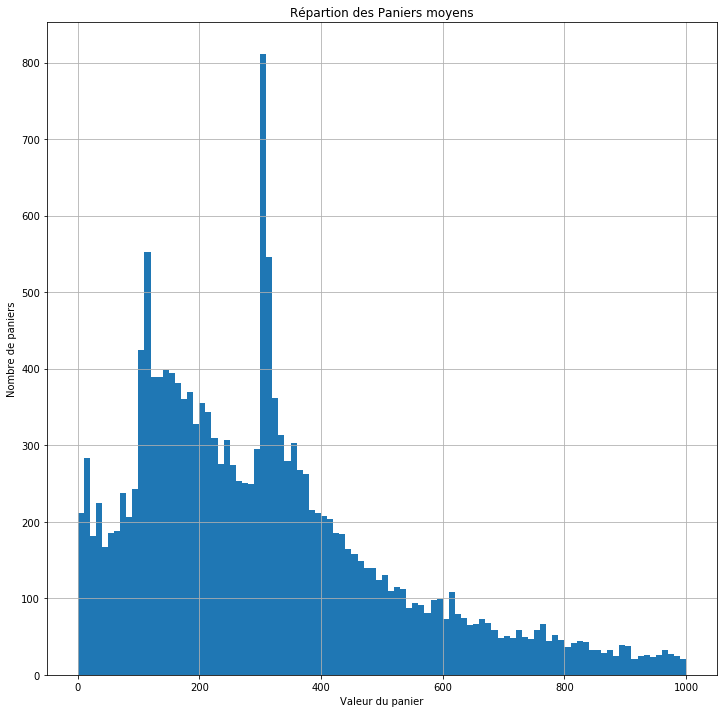

In [93]:
panier_moyen["Price"].hist(range = (0, 1000), bins=100, figsize=(12,12))
plt.title("Répartion des Paniers moyens")
plt.xlabel("Valeur du panier")
plt.ylabel("Nombre de paniers")
plt.savefig("img/cart_hist.png")
plt.show()

On remarque un pic autour des 350 euros, on peut essayer de voir pourquoi

In [94]:
df[(df["Price"] > 300) & (df["Price"] < 400)]

,InvoiceNo,Quantity,UnitPrice,CustomerID,Country,Weekday,Afternoon,Late,Morning,Recency,Price,Cluster
753,546780,24,14.95,12435.0,15,3,0,0,1,267.0,358.80,25
861,571864,24,14.95,12731.0,4,2,1,0,0,50.0,358.80,25
3698,566259,48,6.95,17317.0,0,6,1,0,0,89.0,333.60,17
4646,537667,128,2.55,17870.0,0,2,0,0,1,366.0,326.40,38
4765,572035,128,2.55,14646.0,1,3,1,0,0,50.0,326.40,38
4904,541570,192,1.65,14646.0,1,2,1,0,0,324.0,316.80,25
4977,563076,192,1.65,14646.0,1,3,1,0,0,119.0,316.80,25
6449,567852,36,9.98,18102.0,0,3,1,0,0,77.0,359.28,24
6581,567852,36,9.98,18102.0,0,3,1,0,0,77.0,359.28,24
6845,561645,288,1.25,14911.0,2,3,1,0,0,133.0,360.00,25


Cela semble être du au fait que certains acheteur achettent en grosse quantité un certain produit. Peut-être à cause d'une promotion

### Analyse du CA

A titre informatif, on peut regarder le C/A par jour de la semaine de l'année et le moment de la journée et d'ou sont issues le CA

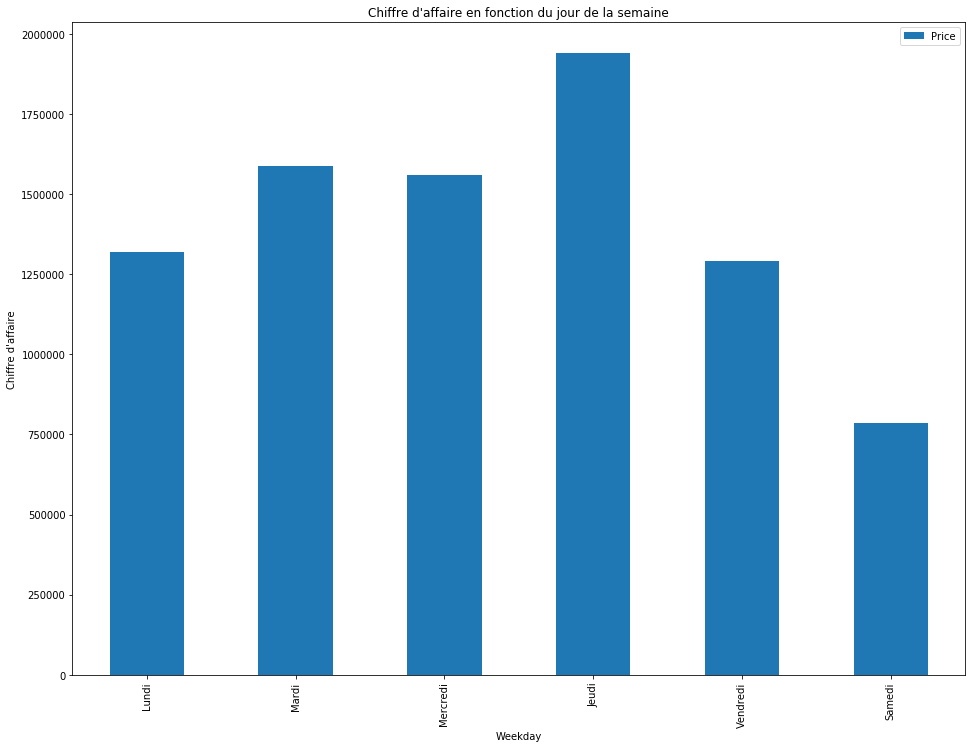

In [95]:
analyse_jour = df.groupby("Weekday").agg({
    #"InvoiceNo" : "count",
    "Price" : "sum"
})

ax = analyse_jour.plot(kind="bar", figsize=(16,12))
ax.set_xticklabels(["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi"])
plt.ylabel("Chiffre d'affaire")
plt.title("Chiffre d'affaire en fonction du jour de la semaine")
plt.savefig("img/CA_week.png")
plt.show()

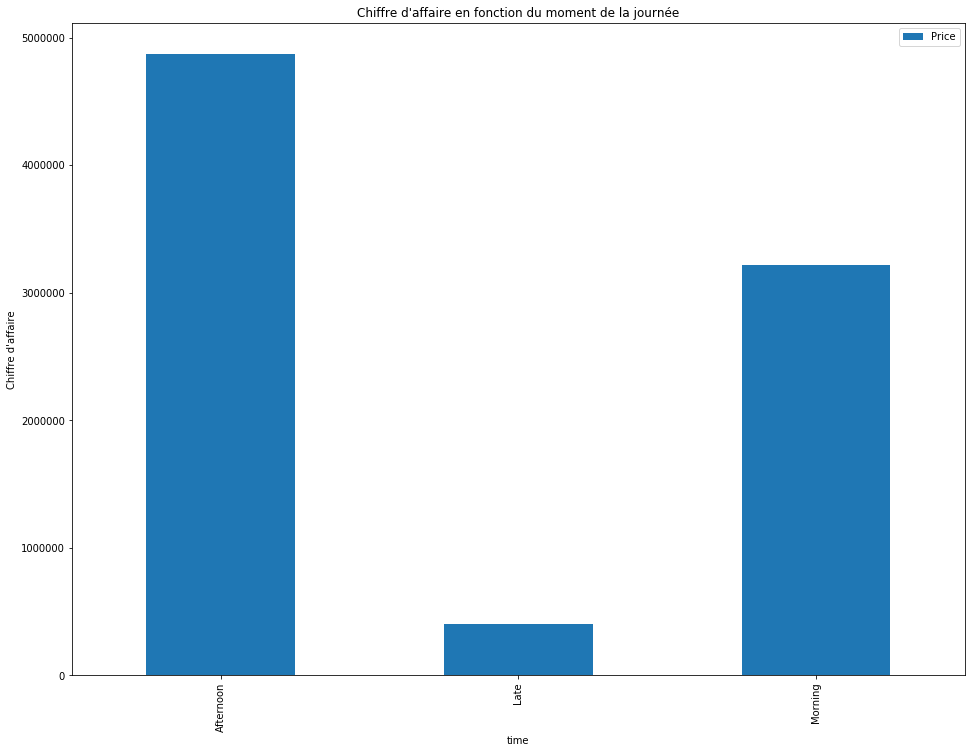

In [96]:
Cat_col = df[["Morning", "Afternoon", "Late"]].idxmax(axis=1)
s2 = pd.concat([Cat_col, df["Price"]], axis=1)
s2.columns=["time", "Price"]

analyse_time = s2.groupby("time").agg({
    "Price" : "sum"
})

analyse_time.plot(kind="bar", figsize=(16,12))
plt.ylabel("Chiffre d'affaire")
plt.title("Chiffre d'affaire en fonction du moment de la journée")
plt.savefig("img/CA_time.png")
plt.show()

Memem si les 3 buckets ne sont pas equitable en terme de durée (Morning dure 6h, afternoon dure 5 et Late dure 3h). On remarque que la grande majorité des ventes se fait l'après-midi

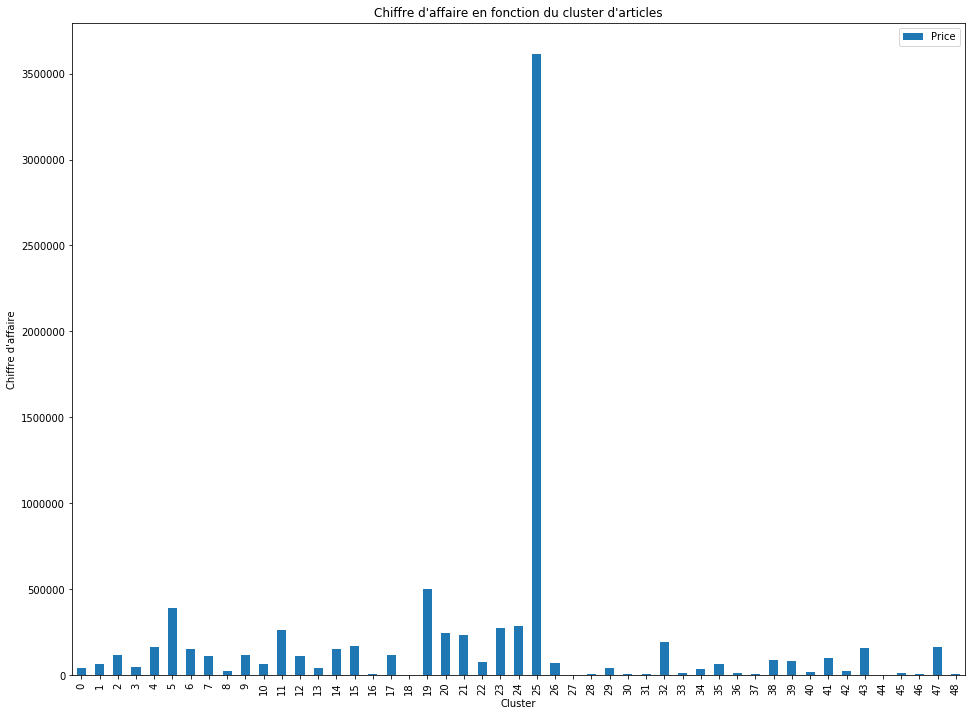

In [97]:
analyse_cluster = df.groupby("Cluster").agg({
    "Price" : "sum"
})

analyse_cluster.plot(kind="bar", figsize=(16,12))
plt.ylabel("Chiffre d'affaire")
plt.title("Chiffre d'affaire en fonction du cluster d'articles")
plt.savefig("img/CA_cluster.png")
plt.show()

Globalement les principaux clusters sont 2, 4, 13, 16, 18. On peut donc regarder leur contenu via des Word Cloud. Cela peut orienter le magasin sur une facon de booster son Chiffre d'affaire.

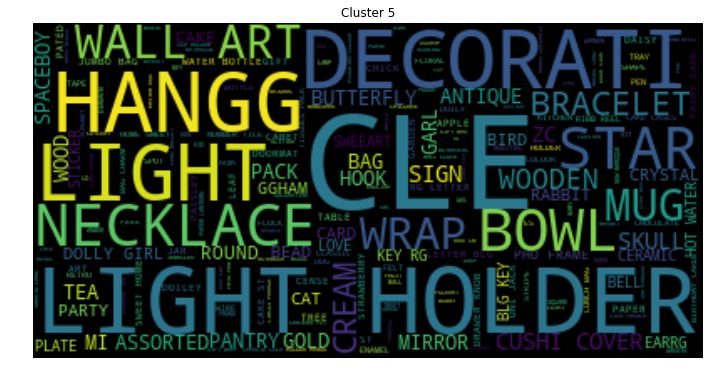

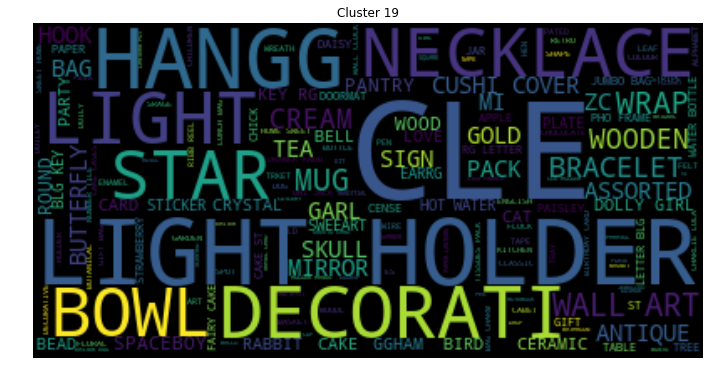

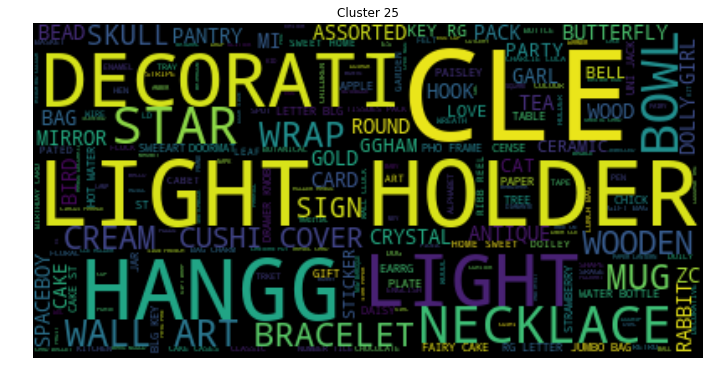

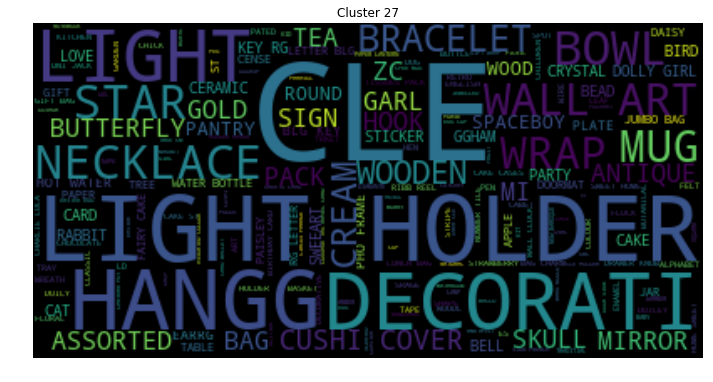

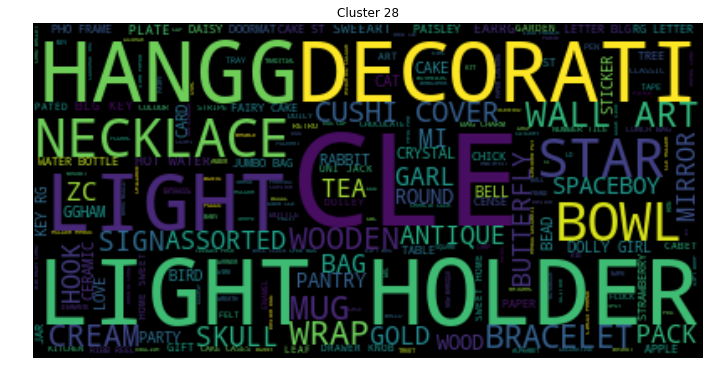

In [98]:
for cluster_num in [5, 19, 25, 27, 28]:
    text = " ".join(df_obj[df_obj["Cluster"] == cluster_num]["Keywords"].tolist())

    wordcloud = WordCloud()
    # wordcloud.generate_from_frequencies(frequencies=cnt)
    wordcloud.generate(" ".join(df_obj["Keywords"].tolist()))
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster {}".format(cluster_num))
    plt.savefig("img/c{}_cloud.png".format(cluster_num))
    plt.show()

On retrouve majoritairement certains mots clé (SET HEART FLOWER RETROSPOT GLASS). Il est assez difficile de trouver une tendance particulière entre les clusters. Peut-être que les mots clés principaux devrait être supprimés ??

# Modélisation

Afin d'effectuer le clustering, on va réutiliser le principe du RFM mais avec plus de features. On peut notament penser à :
<ul>
<li>Panier Moyen par visite</li>
<li>Nombre d'article moyen par visite</li>
<li>Prix moyen des articles par visite</li>
<li>Durée moyenne entre les visites</li>
<li>Dernière visite</li>
<li>Nombre de visite</li>
<li>Pays</li>
<li>Prix dépensé dans chaque cluster d'article</li>
<li>Prix dépensé par jour ou moment de la journée</li>
</ul>

On doit donc préparer pour cela le dataset

In [99]:
df["nb_visits"] = 0
df["price_avg_visits"] = 0
df["recency"] = 0
df["avg_cart"] = 0
df["freq_visit"] = 0
df = pd.concat([df, pd.get_dummies(df["Cluster"], prefix="Cluster_"), pd.get_dummies(df["Weekday"], prefix="Weekday_")], axis=1)

In [100]:
df.drop(["Cluster", "Weekday"], axis=1, inplace=True)

Initiallement, je pensais partir sur la somme dépensé dans chaque cluster. mais les résutats étaient moins pertinent au final. De ce fait je suis repartie sur le nombre d'artciel acheté dans chaque catégorie

In [101]:
# for col in df:
#     if col.startswith(("Cluster", "Weekday")) or col in ["Afternoon", "Late", "Morning"]:
#         df[col] = df[col] * df["Price"]

In [102]:
#df.drop(["Price"], axis=1, inplace=True)

Dans un 1er temps on va faire un groupby invoices puis par clients.

In [104]:
custom_aggregation = {}
custom_aggregation["Price"] = "sum"
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Recency"] = lambda x:x.iloc[0]
custom_aggregation["nb_visits"] = lambda x:1
custom_aggregation["freq_visit"] = lambda x:1
for col in df:
    if col.startswith(("Cluster", "Weekday")):
        custom_aggregation[col] = "sum"
    elif col in ["Afternoon", "Late", "Morning"]:
        custom_aggregation[col] = "mean"

partial_df = df.groupby("InvoiceNo").agg(custom_aggregation)

In [105]:
custom_aggregation = {}
custom_aggregation["nb_visits"] = "count"
custom_aggregation["Quantity"] = "mean"
custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["freq_visit"] = lambda x:1
custom_aggregation["Price"] = "mean"
custom_aggregation["Country"] = lambda x:x.iloc[0]
for col in df:
    if col.startswith(("Cluster", "Weekday")) or col in ["Afternoon", "Late", "Morning"]:
        custom_aggregation[col] = "sum"
        
final_df = partial_df.groupby("CustomerID").agg(custom_aggregation)
final_df["freq_visit"] = (final_df["Recency", "max"] - final_df["Recency", "min"])/final_df["nb_visits", "count"]

On peut maintenant renommer les colonnes du dataset et sauvegardé le résultat

In [107]:
cols = [
    'nb_visits', 
    'Quantity', 
    'Recency_min', 
    'Recency_max', 
    'freq_visit', 
    'Avg_Price', 
    'Country', 
    'Afternoon', 
    'Late', 
    'Morning'
]

for i in range(49):
    cols.append("Cluster_{}".format(i))
for i in range(6):
    cols.append("Weekday_{}".format(i))
    
final_df.columns = cols

In [108]:
final_df.to_csv("final_df.csv")

# Mise en place du Clustering

In [109]:
final_df = pd.read_csv("final_df.csv", index_col=0)

Si on regarde la plupart des features sont répartis avec une moyenne faible et un max assez élevé. De ce fait, afin de conserver la variance, lors du Clustering, on devrait utiliser le StandardScaler. Cependant, afin d'en être sur, on va faire le clustering sur avec les 2 scaling et voir lequel donne de meilleurs résultats

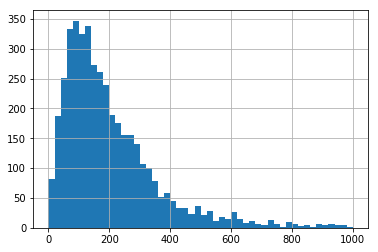

In [110]:
final_df["Quantity"].hist(bins=50, range = (0, 1000))

### Kmeans

In [111]:
y_std = []
y_minmax = []

In [112]:
scaler = StandardScaler()
X_std_scaled = scaler.fit_transform(final_df)

for n_clusters in range(3,45):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_std_scaled)
    clusters = kmeans.predict(X_std_scaled)
    silhouette_avg = silhouette_score(X_std_scaled, clusters)
    y_std.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.615324594022
For n_clusters = 4 The average silhouette_score is : 0.615332088773
For n_clusters = 5 The average silhouette_score is : 0.48389966025
For n_clusters = 6 The average silhouette_score is : 0.474296047641
For n_clusters = 7 The average silhouette_score is : 0.148848741968
For n_clusters = 8 The average silhouette_score is : 0.108422272
For n_clusters = 9 The average silhouette_score is : 0.112928983587
For n_clusters = 10 The average silhouette_score is : 0.0842118665228
For n_clusters = 11 The average silhouette_score is : 0.0836338195955
For n_clusters = 12 The average silhouette_score is : 0.0854750454335
For n_clusters = 13 The average silhouette_score is : 0.0916386782005
For n_clusters = 14 The average silhouette_score is : 0.0938444522497
For n_clusters = 15 The average silhouette_score is : 0.0905017977023
For n_clusters = 16 The average silhouette_score is : 0.0889553465546
For n_clusters = 17 The average silhou

In [113]:
scaler = MinMaxScaler()
X_minmax_scaled = scaler.fit_transform(final_df)

for n_clusters in range(3,45):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_minmax_scaled)
    clusters = kmeans.predict(X_minmax_scaled)
    silhouette_avg = silhouette_score(X_minmax_scaled, clusters)
    y_minmax.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.417796098322
For n_clusters = 4 The average silhouette_score is : 0.421888282124
For n_clusters = 5 The average silhouette_score is : 0.357095367159
For n_clusters = 6 The average silhouette_score is : 0.30521981089
For n_clusters = 7 The average silhouette_score is : 0.304547398658
For n_clusters = 8 The average silhouette_score is : 0.307597722755
For n_clusters = 9 The average silhouette_score is : 0.316977657643
For n_clusters = 10 The average silhouette_score is : 0.288404467697
For n_clusters = 11 The average silhouette_score is : 0.283608144622
For n_clusters = 12 The average silhouette_score is : 0.269977129834
For n_clusters = 13 The average silhouette_score is : 0.285595794136
For n_clusters = 14 The average silhouette_score is : 0.269189127365
For n_clusters = 15 The average silhouette_score is : 0.212845539379
For n_clusters = 16 The average silhouette_score is : 0.256809252918
For n_clusters = 17 The average silhouette

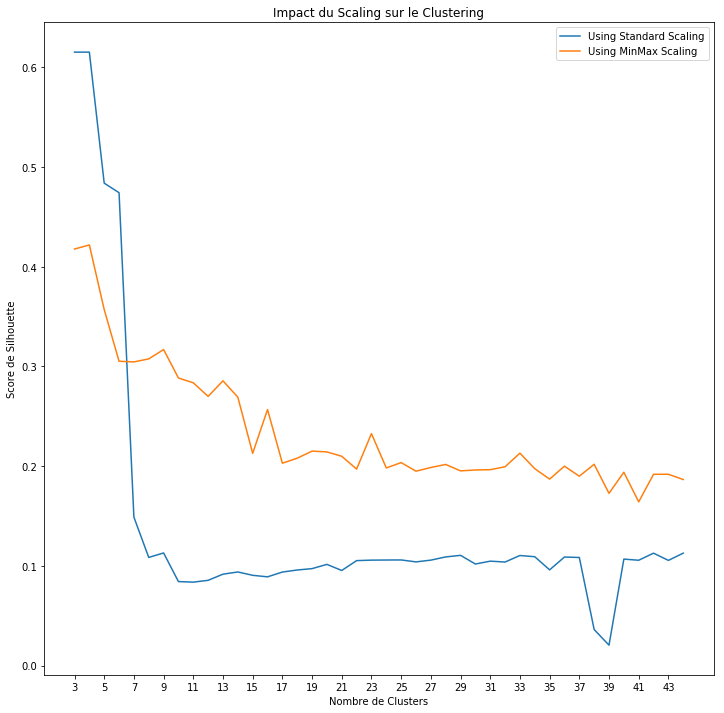

In [114]:
plt.figure(figsize=(12,12))
plt.plot(list(range(3,45)), y_std, label="Using Standard Scaling")
plt.plot(list(range(3,45)), y_minmax, label="Using MinMax Scaling")
plt.legend()
plt.xlabel("Nombre de Clusters")
plt.ylabel("Score de Silhouette")
plt.title("Impact du Scaling sur le Clustering")
plt.xticks(list(range(3,45, 2)))
plt.savefig("img/scaling.png")
plt.show()

Maintenant que l'on connais le Scaler adapté, on peut chercher le nb de clusters pour la ségmentation des clients. Pour ce faire dans un 1er temps je voulais regarder la variation du score de silhouette en fonction du nombre d'initiallisations et on trouve :
<img src="img/silhouette.png" />

Cependant, comme avec n_init le modèle est testé n fois et seulement le meiller résultat est gardé, on peut chercher le nb de clusters comme précédemmeent

In [ ]:
# cluster_n = []
# silhouette = []

# for n_clusters in range(3,45):
#     for i in range(30): # pour avoir les 10 inits du Kmeans mais récupérer tous les résultats
#         kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=1)
#         kmeans.fit(X_std_scaled)
#         clusters = kmeans.predict(X_std_scaled)
#         silhouette_avg = silhouette_score(X_std_scaled, clusters)
#         cluster_n.append(n_clusters)
#         silhouette.append(silhouette_avg)
#     #print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

In [ ]:
# boxplot_df = pd.DataFrame({"Cluster" : cluster_n, "Silhouette" : silhouette})

In [ ]:
# plt.figure(figsize=(20,12))
# sns.boxplot(y="Silhouette", x="Cluster", data=boxplot_df)
# plt.title("Evolution du Silhouette Score en fonction du nb de clusters")
# plt.savefig("img/silhouette.png")
# plt.show()

In [116]:
for n_clusters in range(3,20):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=20)
    kmeans.fit(X_std_scaled)
    clusters = kmeans.predict(X_std_scaled)
    silhouette_avg = silhouette_score(X_std_scaled, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.615324594022
For n_clusters = 4 The average silhouette_score is : 0.628883773316
For n_clusters = 5 The average silhouette_score is : 0.48389966025
For n_clusters = 6 The average silhouette_score is : 0.527213542544
For n_clusters = 7 The average silhouette_score is : 0.147199439666
For n_clusters = 8 The average silhouette_score is : 0.131099664131
For n_clusters = 9 The average silhouette_score is : 0.0838647661158
For n_clusters = 10 The average silhouette_score is : 0.0833083098627
For n_clusters = 11 The average silhouette_score is : 0.0866199720668
For n_clusters = 12 The average silhouette_score is : 0.0866496805395
For n_clusters = 13 The average silhouette_score is : 0.0855693116864
For n_clusters = 14 The average silhouette_score is : 0.0928543151951
For n_clusters = 15 The average silhouette_score is : 0.0922064779467
For n_clusters = 16 The average silhouette_score is : 0.0983218243665
For n_clusters = 17 The average si

On remarque que les meilleurs clustering sont autour de 45 clusters. Cependant, avec 45 clusters il sera difficile de visualiser la différence entre un client ou un autre selon les features. Deplus avec peu de clients, on risque d'avoir pas mal de cluster avec seulemetn quelques personnes. De ce faite, il faut un nombre assez restreint et 8 cluster est le plus petit cluster avec un score de silhouette assez faible

In [122]:
kmeans = KMeans(init='k-means++', n_clusters = 13, n_init=30)
X_embedded = kmeans.fit_transform(X_minmax_scaled)
final_df["Customer_group"] = kmeans.labels_

#### Exploration du résultat

On peut de la même manière que pour les objets, visualiser le clustering à l'aide du TSNE. D'autres modèles du groupe des manifolds ont aussi été testés mais donnent de moins bons résultats. Les codes sont donc commentés

In [ ]:
# fig = plt.figure(figsize=(13,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=kmeans.labels_, cmap="jet")
# plt.title("Kmeans projected in 3D")
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# plt.savefig("img/kmeans3d.png")
# plt.show()

In [ ]:
# tsne = TSNE(n_components=3)
# X_embedded = tsne.fit_transform(X_std_scaled)
# color = kmeans.labels_

# fig = plt.figure(figsize=(13,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=color)
# ax.set_title("TSNE 3D")
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# plt.savefig("img/TSNE_3D.png")
# plt.show()

In [123]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X_minmax_scaled)
color = kmeans.labels_

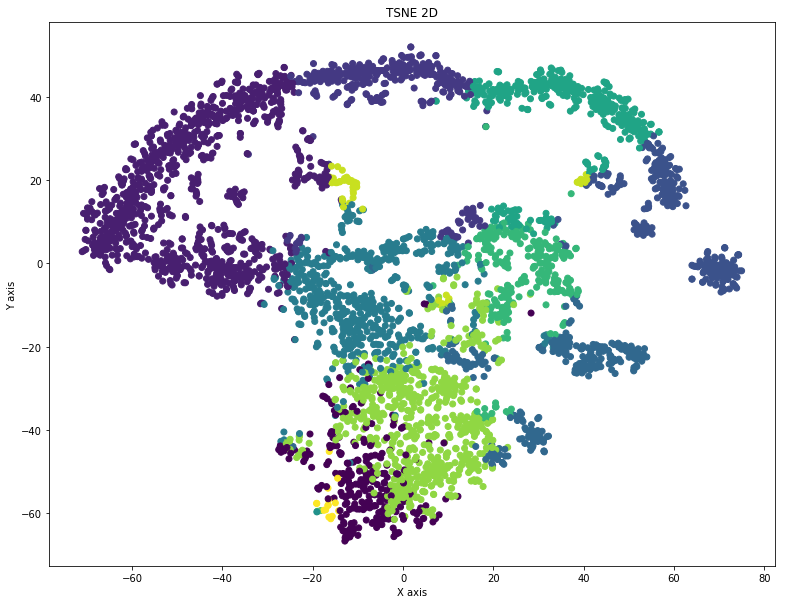

In [124]:
plt.figure(figsize=(13,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color)
plt.title("TSNE 2D")
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.savefig("img/TSNE_customer_2D.png")
plt.show()

In [ ]:
# iso = Isomap(n_neighbors=10, n_components=3)
# pos = iso.fit_transform(X_std_scaled)

# fig = plt.figure(figsize=(13,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c = color)
# ax.set_title("Isomap projected in 3D")
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# plt.savefig("img/isomap3d.png")
# plt.show()

In [ ]:
# lle = locally_linear_embedding(X_std_scaled, n_neighbors=20, n_components=3)
# pos = lle[0]
# fig = plt.figure(figsize=(13,10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c = color)
# ax.set_title("Isomap projected in 3D")
# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# plt.savefig("img/lle3d.png")
# plt.show()

Le résultat ne parrait pas terrible. On peut aussi regarde au niveau des valeurs. Ainsi que le nombre de personne dans chaque clusters

In [125]:
def proportion(x):
    nb_abroad = x.astype(bool).sum(axis=0)
    nb_total = len(x)
    return (nb_total-nb_abroad)/nb_total

In [126]:
final_df["count_cluster"] = 1

visu = final_df.groupby("Customer_group").agg({
    "nb_visits" : "mean",
    "Quantity" : "mean",
    "Recency_min" : "mean",
    "freq_visit" : "mean",
    "Avg_Price" : "mean",
    "Country" : proportion,
    "Afternoon" : "sum",
    "Late" : "sum",
    "Morning" : "sum",
    "count_cluster" : "sum"
})
visu

,nb_visits,Quantity,Recency_min,freq_visit,Avg_Price,Country,Afternoon,Late,Morning,count_cluster
Customer_group,,,,,,,,,,
0,18.132075,309.492801,11.332075,23.697841,551.777568,0.913208,2807.000000,235,1763.000000,265
1,1.733207,252.114771,36.333964,5.823993,375.769970,0.917692,1190.000000,89,553.000000,1057
2,1.444126,221.094102,145.143266,3.999618,369.031957,0.931232,319.000000,34,151.000000,349
3,1.453333,165.388291,333.266667,2.819391,306.754202,0.876667,262.000000,16,158.000000,300
4,2.501538,200.631538,41.163077,115.452821,334.655736,0.929231,505.000000,43,265.000000,325
5,4.104907,234.483035,35.749577,47.988609,362.305861,0.901861,1490.000000,104,832.000000,591
6,122.000000,187.680328,1.000000,3.040984,333.943689,1.000000,89.000000,6,27.000000,1
7,1.279898,187.629700,244.137405,2.839779,332.275326,0.936387,304.000000,29,170.000000,393
8,3.221831,214.280022,163.845070,52.674075,358.710388,0.943662,548.000000,48,319.000000,284


Déjà avec 8 clusters, on a 4 clusters presque vide. Cela ocnfirme le fait qu'aller a 45 clusters créerait beaucoup de disparités. Sans regardé le partage dans les clusters, on peut visualiser les tendance dans un barpolt 3D avec le profondeur le cluster voulu

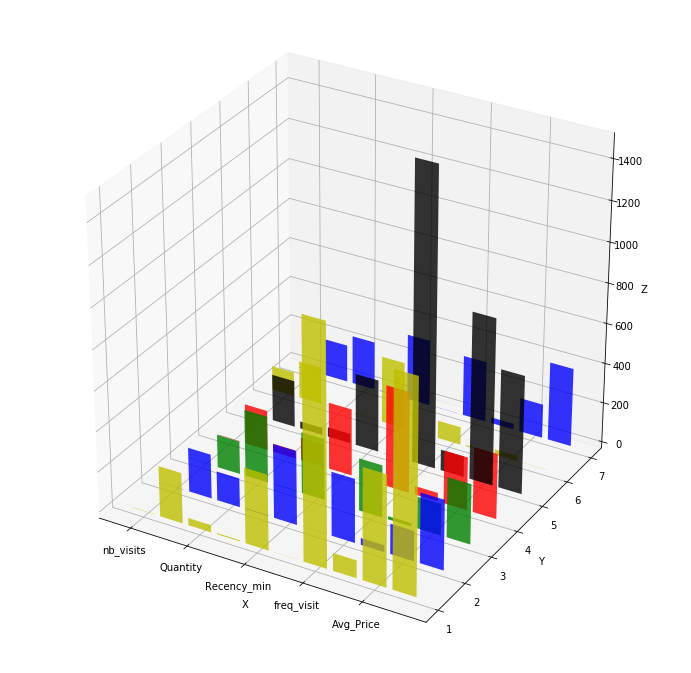

In [127]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

colors = ['b', 'y', "k", 'r', 'g', 'b', 'y', "k"]
yticks = list(range(7, 0, -1))
for c, k in zip(colors, yticks):
    xs = np.arange(10)
    ys = visu.as_matrix()[k, :]
    ax.bar(xs, ys, zs=k, zdir='y', color=c, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# On the y axis let's only label the discrete values that we have data for.
ax.set_yticks(yticks)
ax.set_xticklabels(list(visu))
plt.show()

In [128]:
final_df.to_csv("final_df_with_cluster.csv")

# Classifieur

On a maintenant nos clients qui ont comme label des clusters. On peut donc mettre en place un Classifieur avec pour objectif d'avoir un modèle permettant de prédire dans quelle catégorie tombe un client en focntion de son historique d'achat sur le site

In [129]:
final_df = pd.read_csv("final_df_with_cluster.csv", index_col=0)

In [130]:
X = final_df.drop(["count_cluster", "Customer_group"], axis=1)
y = final_df["Customer_group"] 

On va donc réutiliser le Standard Scaler et dans un 1er temps splitter le dataset juste pour évaluser les modèles avec de fine-tune le meilleur

In [145]:
scaler = StandardScaler()
X_std_scaled = scaler.fit_transform(X)
scaler = MinMaxScaler()
X_minmax_scaled = scaler.fit_transform(X)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax_scaled, y, test_size=0.15, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std_scaled, y, test_size=0.15, random_state=42)

## KNN

Pour le KNN, on va l'évaluer en regardant par rapport au nombre de voisins aussi

In [147]:
for voisin in range(1,12):
    neigh = KNeighborsClassifier(n_neighbors=voisin)
    neigh.fit(X_train, y_train) 
    print(voisin, neigh.score(X_test, y_test))

1 0.910769230769
2 0.913846153846
3 0.918461538462
4 0.924615384615
5 0.935384615385
6 0.938461538462
7 0.946153846154
8 0.941538461538
9 0.938461538462
10 0.932307692308
11 0.936923076923


## SVC

In [148]:
clf = SVC()
clf.fit(X_train, y_train) 
print(clf.score(X_test, y_test))

0.690769230769


## Naive Bayes

In [149]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(gnb.score(X_test, y_test))

0.415384615385


## Decision Tree

Comme on a un nombre de données limité, le decision tree va être testé avec certains level de profondeur mais resteint pour ne pas overfitter le dataset

In [150]:
for max_depth in range(3, 10):
    clf = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    clf.fit(X_train, y_train)
    print(max_depth, clf.score(X_test, y_test))

3 0.683076923077
4 0.812307692308
5 0.92
6 0.913846153846
7 0.929230769231
8 0.936923076923
9 0.929230769231


## Random Forest

On peut de la même manière regarder si le Random Forest fonctionne e mieux que le Random Tree

In [151]:
for max_depth in range(3, 20):
    clf = RandomForestClassifier(random_state=0, max_depth=max_depth, n_estimators=100)
    clf.fit(X_train, y_train)
    print(max_depth, clf.score(X_test, y_test))

3 0.732307692308
4 0.886153846154
5 0.921538461538
6 0.910769230769
7 0.924615384615
8 0.929230769231
9 0.933846153846
10 0.933846153846
11 0.938461538462
12 0.949230769231
13 0.944615384615
14 0.944615384615
15 0.950769230769
16 0.944615384615
17 0.943076923077
18 0.941538461538
19 0.950769230769


Le modèle est en effet plus performant mais le SVC reste tout de même beaucoup au dessus. On va donc maintenant faire le fine tuning

# Fine Tuning

## V1 (précédent clustering)

Dasn un 1er cas, on peut essayer d'entrainer le SVC dans une configuration One-vs One ou One-vs-all. C'est généralement prevu pour les modèle linéaires mais cela faut tout de meme le coup d'essayer

In [240]:
# ovo = OneVsOneClassifier(SVC())
# ovo.fit(X_train_std, y_train_std)
# print(ovo.score(X_test_std, y_test_std))

0.970769230769


In [241]:
# ova = OneVsRestClassifier(SVC())
# ova.fit(X_train_std, y_train_std)
# print(ova.score(X_test_std, y_test_std))

0.969230769231


Le OVO fonctionne mieux que le OVA mais ne performe pas mieux que le simple SVC. On va donc maintenant chercher les meillers paramètres suivant un Grid Search. Ce grid Search sera fait en cross validation pour éviter tout overfitting comme le dataset est assez petit. Par contre un des points pénalisation de ce clustering est que certains groupe n'ont qu'un seul element car il y a des clusters presque vide

In [251]:
# parameters = {
#     'kernel':['rbf'],   # on va rester en rbf 
#     'C': [0.01, 0.1 ,1, 10, 100],
#     'tol' : [1e-3, 1e-2, 1e-1]
# }
# svc = SVC()
# clf = GridSearchCV(svc, parameters, cv=5, scoring="accuracy")
# clf.fit(X_std_scaled, y)

C:\Anaconda501\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [0.01, 0.1, 1, 10, 100], 'tol': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [256]:
# cvres = clf.cv_results_
# for acc, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(acc, params)
# print("\n", clf.best_params_)

0.834987306716 {'C': 0.01, 'kernel': 'rbf', 'tol': 0.001}
0.834525732749 {'C': 0.01, 'kernel': 'rbf', 'tol': 0.01}
0.831987075929 {'C': 0.01, 'kernel': 'rbf', 'tol': 0.1}
0.940456958228 {'C': 0.1, 'kernel': 'rbf', 'tol': 0.001}
0.940687745211 {'C': 0.1, 'kernel': 'rbf', 'tol': 0.01}
0.940918532195 {'C': 0.1, 'kernel': 'rbf', 'tol': 0.1}
0.965151165474 {'C': 1, 'kernel': 'rbf', 'tol': 0.001}
0.965151165474 {'C': 1, 'kernel': 'rbf', 'tol': 0.01}
0.964458804523 {'C': 1, 'kernel': 'rbf', 'tol': 0.1}
0.967689822294 {'C': 10, 'kernel': 'rbf', 'tol': 0.001}
0.967689822294 {'C': 10, 'kernel': 'rbf', 'tol': 0.01}
0.966535887376 {'C': 10, 'kernel': 'rbf', 'tol': 0.1}
0.966074313409 {'C': 100, 'kernel': 'rbf', 'tol': 0.001}
0.966074313409 {'C': 100, 'kernel': 'rbf', 'tol': 0.01}
0.966535887376 {'C': 100, 'kernel': 'rbf', 'tol': 0.1}

 {'C': 10, 'kernel': 'rbf', 'tol': 0.001}


## V2 ( Nouveau Clustering)

In [153]:
parameters = {
    'n_estimators':[5, 10, 20, 30, 50],   # on va rester en rbf 
    'max_features': [None, "sqrt", "log2"],
    'max_depth' : [3, 5, 10, 12, 15],
    'min_samples_leaf' : [1, 2, 3, 5]
}
RFC = RandomForestClassifier()
clf = GridSearchCV(RFC, parameters, cv=3, scoring="accuracy")
clf.fit(X_minmax_scaled, y)

C:\Anaconda501\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20, 30, 50], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [3, 5, 10, 12, 15], 'min_samples_leaf': [1, 2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [154]:
cvres = clf.cv_results_
for acc, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(acc, params)
print("\n", clf.best_params_)

0.70690053081 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 5}
0.751903992615 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 10}
0.754442649435 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 20}
0.753057927533 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 30}
0.754211862451 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}
0.751903992615 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 5}
0.751673205631 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 10}
0.752134779598 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 20}
0.752596353566 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 30}
0.754442649435 {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 50}
0.722594045696 {'max_depth': 3, '

On a maintenant les meilleurs paramètres, on peut donc re-découper le dataset en train/test et l'evaluer de cette manière

In [157]:
def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("img/confusion.png")

Confusion matrix, without normalization
[[ 34   0   0   0   0   0   0   0   0   7   0   0]
 [  0 160   0   0   0   1   0   0   0   0   1   0]
 [  0   0  46   0   0   3   0   1   0   0   0   0]
 [  0   0   0  43   0   0   0   0   0   0   1   0]
 [  0   0   0   0  51   0   0   1   0   1   0   0]
 [  1   0   0   0   0  88   0   0   0   0   0   0]
 [  0   0   0   0   0   0  49   2   0   0   0   0]
 [  0   0   0   1   0   1   0  42   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]
 [  8   0   0   0   1   0   0   1   0  96   0   0]
 [  0   0   3   0   0   1   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1]]


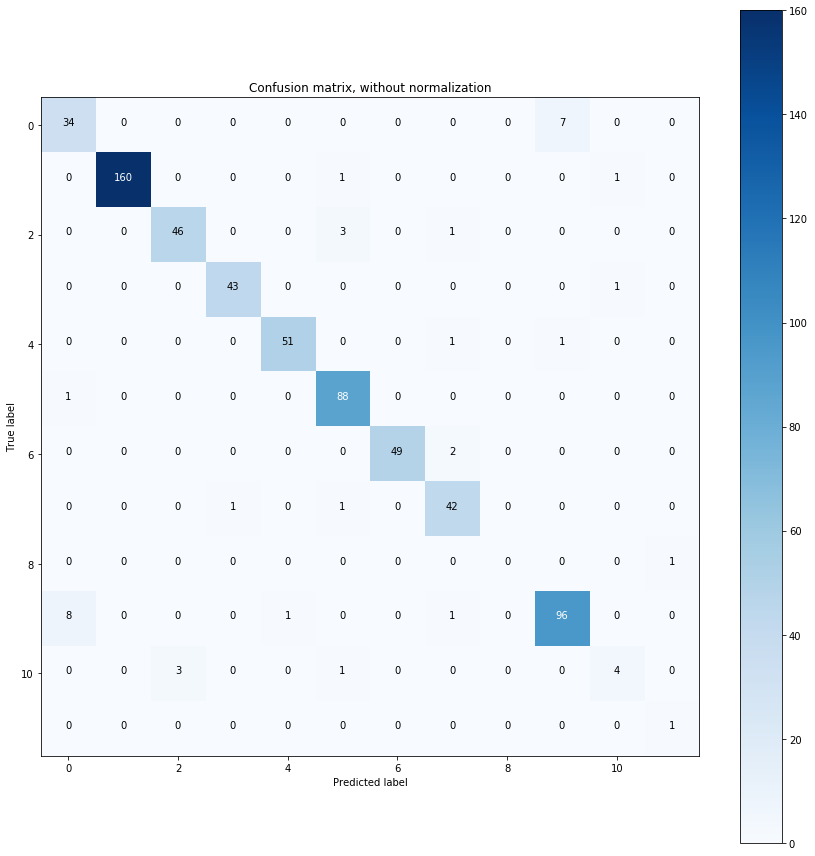

In [158]:
final_estimator = clf.best_estimator_ 

final_estimator.fit(X_train, y_train)
y_pred = final_estimator.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize = (12,12))
plot_confusion_matrix(cnf_matrix, title='Confusion matrix, without normalization')

plt.show()

# Conclusion